In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from  sklearn.decomposition import PCA
import scipy.optimize as opt

# Первая задача

In [4]:
# подключаем 3D графики
# %matplotlib widget

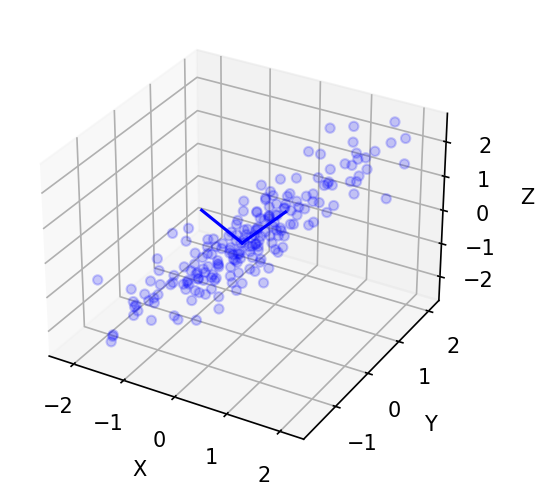

In [5]:
N = 200

# генерируем матрицу A
A = np.random.random((3, 3))
A = A@A.T

# получаем многомерное нормальное гауссово распределение
X = np.random.multivariate_normal([0,0,0], A, N)
x, y, z = X.T

# PCA decomposition
pca = PCA(n_components=2)
data = pca.fit_transform(X)
B = pca.transform(A)

# визуализируем
fig = plt.figure(dpi=150)
ax = fig.add_subplot(projection='3d')

ax.scatter(x, y, z, color="b", alpha=0.2)


x0, y0, z0 = pca.components_[0];
ax.plot([0, x0], [0, y0], [0, z0], color="b")

x1, y1, z1 = pca.components_[1];
ax.plot([0, x1], [0, y1], [0, z1], color="b")
    

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

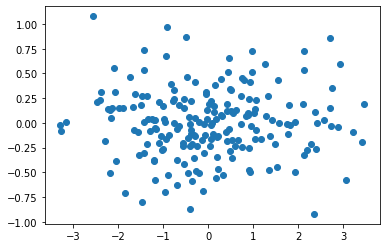

In [6]:
B = pca.transform(X)
x, y = B.T
plt.figure()
plt.scatter(x, y)
plt.show()

# Шестая задача

## Инициализация

In [48]:
# сгенерируем выборку
N = 20000;

alpha_val = 0.55;
mu1_val   = -3;
mu2_val   = 3;
sigma1_val= 1;
sigma2_val= 3;

params_true = [alpha_val, [sigma1_val, mu1_val], [sigma2_val, mu2_val]]

N1 = int(np.round((alpha_val * N)));
N2 = int(np.round(((1 - alpha_val) * N)));
v1 = np.random.normal(loc=mu1_val, scale=sigma1_val, size=N1)
v2 = np.random.normal(loc=mu2_val, scale=sigma2_val, size=N2)
dots = np.hstack([v1, v2])

In [49]:
def get_p(x, sigma, mu, alpha):
    coef = 1 / np.sqrt(2 * np.pi * sigma)
    return alpha * coef * np.exp(- (x-mu)**2 / 2 / sigma**2)

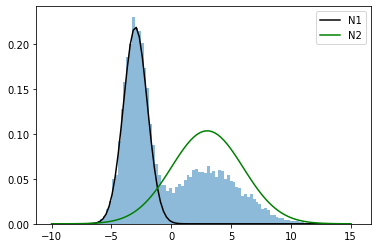

In [50]:
# проверим, что всё правильно: визуализация
x0 = np.linspace(-10, 15, 100)
plt.hist(dots, bins=100, density=True, alpha=0.5)
plt.plot(x0, get_p(x0, sigma1_val, mu1_val, alpha_val), color="k", label="N1")
plt.plot(x0, get_p(x0, sigma2_val, mu2_val, 1-alpha_val), color="g", label="N2")

plt.legend()
plt.show()

In [51]:
def get_a(x, alpha, vals1, vals2):
    p1 = get_p(x, vals1[0], vals1[1], alpha)
    p2 = get_p(x, vals2[0], vals2[1], 1-alpha)
    
    if p1 >= p2: return 1
    return 2

In [52]:
# сгенерируем предположение параметры
def init_params():
    alpha_init = np.random.uniform(0.3, 0.7)
    mu1_init = np.random.uniform(-5, -1)
    mu2_init = np.random.uniform(1, 5)
    sigma1_init = np.random.uniform(0.1, 2)
    sigma2_init = np.random.uniform(0.1, 2)
    
    vals1_init = np.array([sigma1_init, mu1_init])
    vals2_init = np.array([sigma2_init, mu2_init])
    return [alpha_init, vals1_init, vals2_init]

## Оптимизация

In [53]:
def print_params(params, params_true):
    print("         pred | true".format(params[0], params_true[0]))
    print("alpha | {:.3f} | {:.2f}".format(params[0], params_true[0]))
    print("mu1   |{:.3f} | {:.2f}".format(params[1][1], params_true[1][1]))
    print("mu2   | {:.3f} | {:.2f}".format(params[2][1], params_true[2][1]))
    print("sigma1| {:.3f} | {:.2f}".format(params[1][0], params_true[1][0]))
    print("sigma2| {:.3f} | {:.2f}".format(params[2][0], params_true[2][0]))

In [64]:
epsilon = 1e-8;

def get_f_to_max1(params):
    m1 = (np.array([get_a(x, *params) for x in dots]) == 1)
    def f_to_max1(opt_params):
        return -np.sum(np.log(epsilon + get_p(dots[m1], opt_params[0]**2, opt_params[1], params[0])))
    
    return f_to_max1


def get_f_to_max2(params):
    m2 = (np.array([get_a(x, *params) for x in dots]) == 2)
    def f_to_max2(opt_params):
        return -np.sum(np.log(epsilon + get_p(dots[m2], opt_params[0]**2, opt_params[1], params[0])))
    
    return f_to_max2
    
    
def get_f_to_max_alpha(params):
    def f_to_max_alpha(alpha):
        p1 = get_p(dots, params[1][0], params[1][1], alpha)
        p2 = get_p(dots, params[2][0], params[2][1], 1-alpha)
        return -np.sum(np.log(epsilon + p1 + p2))
    
    return f_to_max_alpha

In [65]:
def do_step(params):
    init_alpha   =  params[0]
    init_params1 =  params[1]
    init_params2 =  params[2]

    result1 =  opt.minimize(get_f_to_max1(params), init_params1)
    sigma1_, mu1_ = result1.x
    res1 = np.array([sigma1_**2, mu1_])

    result2 =  opt.minimize(get_f_to_max2(params), init_params2)
    sigma2_, mu2_ = result2.x
    res2 = np.array([sigma2_**2, mu2_])

    result_alpha =  opt.minimize(get_f_to_max_alpha(params), init_alpha, bounds = [(0, 1)])
    res_alpha = result_alpha.x[0]

    return [res_alpha, res1, res2]

In [66]:
def flat_params(params):
    tmp = params.copy()
    tmp[0] = [tmp[0]]
    return np.concatenate(tmp)

In [67]:
def do_n_steps(n, init_params):
    history = flat_params(init_params)
    params = init_params.copy()
    for i in range(n):
        params = do_step(params)
        history = np.vstack([history, flat_params(params)])
    return params, history

In [87]:
# инициализируем параметры
params = init_params()
print_params(params, params_true)

         pred | true
alpha | 0.492 | 0.55
mu1   |-2.947 | -3.00
mu2   | 3.416 | 3.00
sigma1| 1.257 | 1.00
sigma2| 1.005 | 3.00


In [88]:
fin_params, history = do_n_steps(20, params)
print_params(fin_params, params_true)

         pred | true
alpha | 0.552 | 0.55
mu1   |-2.923 | -3.00
mu2   | 3.670 | 3.00
sigma1| 1.492 | 1.00
sigma2| 3.476 | 3.00


In [83]:
# посмотрим на эволюцию
data = history

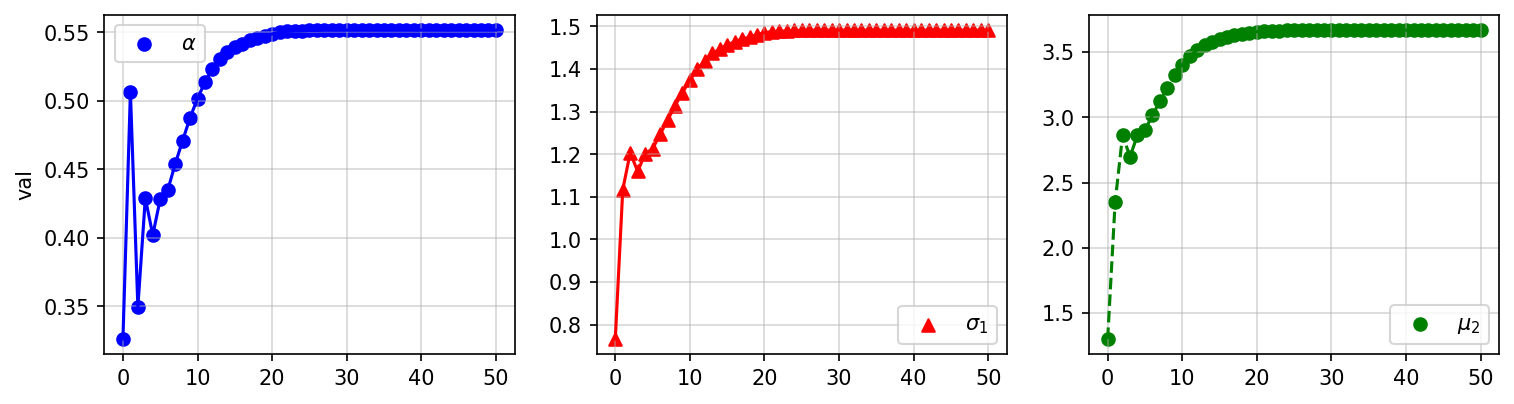

In [84]:
# bor = 100
X = list(range(data.shape[0]))
fig, axs = plt.subplots(1, 3, figsize=(12, 3), dpi=150)
axs[0].plot(X, data[:, 0], color="b")
axs[0].scatter(X, data[:, 0], label="$\\alpha$", color="b")

axs[1].plot(X, data[:, 1], color="r")
axs[1].scatter(X, data[:, 1], label="$\\sigma_1$", color="r", marker="^")
# axs[1].plot(X, data[:, 2], "--", color="r")
# axs[1].scatter(X, data[:, 2], label="$\\mu_1$", color="r")

# axs[2].plot(X, data[:, 3], color="g")
# axs[2].scatter(X, data[:, 3], label="$\\sigma_2$", color="g", marker="^")
axs[2].plot(X, data[:, 4], "--", color="g")
axs[2].scatter(X, data[:, 4], label="$\\mu_2$", color="g")


# axs[0].set_ylim(-bor, bor)
# axs[1].set_ylim(-bor, bor)
# axs[2].set_ylim(-bor, bor)
axs[0].legend()
axs[1].legend()
axs[2].legend()
axs[0].grid(alpha=0.5)
axs[1].grid(alpha=0.5)
axs[2].grid(alpha=0.5)
axs[0].set_ylabel("val")
plt.show()

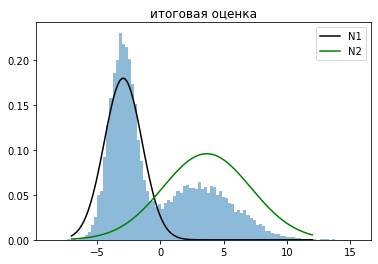

In [86]:
# посмотрим на получившиеся распределения
x0 = np.linspace(-7, 12, 100)
plt.hist(dots, bins=100, density=True, alpha=0.5)
plt.plot(x0, get_p(x0, fin_params[1][0], fin_params[1][1], fin_params[0]), color="k", label="N1")
plt.plot(x0, get_p(x0, fin_params[2][0], fin_params[2][1], 1-fin_params[0]), color="g", label="N2")

plt.title("итоговая оценка")
plt.legend()
plt.show()

Оценка получается смещенной, не совсем понятно почему так. Возможно проблема в не совсем корректной генерации данных. 

При этом $\alpha$ оценивается точно.

Посмотрим также на устойчивость к различным init params

In [89]:
fin_params, history = do_n_steps(20, init_params())
print_params(fin_params, params_true)

         pred | true
alpha | 0.552 | 0.55
mu1   |-2.924 | -3.00
mu2   | 3.669 | 3.00
sigma1| 1.491 | 1.00
sigma2| 3.477 | 3.00


In [90]:
fin_params, history = do_n_steps(20, init_params())
print_params(fin_params, params_true)

         pred | true
alpha | 0.552 | 0.55
mu1   |-2.923 | -3.00
mu2   | 3.670 | 3.00
sigma1| 1.492 | 1.00
sigma2| 3.476 | 3.00


In [91]:
fin_params, history = do_n_steps(20, init_params())
print_params(fin_params, params_true)

         pred | true
alpha | 0.552 | 0.55
mu1   |-2.923 | -3.00
mu2   | 3.670 | 3.00
sigma1| 1.492 | 1.00
sigma2| 3.476 | 3.00


Устойчиво.